<a href="https://colab.research.google.com/github/ccapelo8/learning-pytorch/blob/main/Pytorch_by_freeCodeCamp_Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 2

This chapter lectures about classifcation neural networks

#**60-83. Classification NN**

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


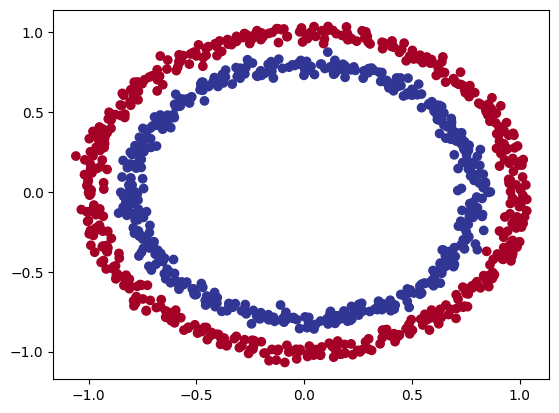

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu)

We need to turn the data into tensors

In [6]:
import torch

type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

type(X),type(y)

(torch.Tensor, torch.Tensor)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)


In [9]:
len(X_train), len(X_test)

(800, 200)

In [10]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
from sklearn import datasets

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features =2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, X):
    return self.layer_2(self.layer_1(x))

model_01 = CircleModelV0().to(device)
model_01




CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

There is a way easier way to build "simple" models with nn.Sequential

In [12]:
model_01 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_01

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
untrained_preds = model_01(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}), Shape: {untrained_preds.shape} ")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\n Frist 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200), Shape: torch.Size([200, 1]) 
Length of test samples: 200, Shape: torch.Size([200, 2])

 Frist 10 predictions: 
tensor([[-0.0202],
        [ 0.0640],
        [-0.2764],
        [ 0.0525],
        [-0.3325],
        [-0.2807],
        [ 0.0010],
        [-0.0799],
        [-0.2737],
        [ 0.0690]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [14]:
loss_fn01 = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_01.parameters(),
                            lr=0.1)

In [15]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [16]:
model_01.eval()
with torch.inference_mode():
  y_logits = model_01(X_test.to(device))[:5]
y_logits

tensor([[-0.0202],
        [ 0.0640],
        [-0.2764],
        [ 0.0525],
        [-0.3325]], device='cuda:0')

In [17]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4949],
        [0.5160],
        [0.4313],
        [0.5131],
        [0.4176]], device='cuda:0')

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_01(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 0., 1., 0.], device='cuda:0')

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_01.train()

  y_logits = model_01(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn01(y_logits,
                   y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #Testing
  model_01.eval()
  with torch.inference_mode():
    test_logits = model_01(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

  test_loss = loss_fn01(test_logits,
                        y_test)
  test_acc = accuracy_fn(y_true = y_test,
                         y_pred = test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69858, Accuracy: 44.50% | Test loss: 0.70441, Test acc: 47.00
Epoch: 100 | Loss: 0.69310, Accuracy: 50.75% | Test loss: 0.69597, Test acc: 47.00
Epoch: 200 | Loss: 0.69300, Accuracy: 51.25% | Test loss: 0.69509, Test acc: 47.00
Epoch: 300 | Loss: 0.69299, Accuracy: 51.00% | Test loss: 0.69482, Test acc: 47.00
Epoch: 400 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69473, Test acc: 46.50
Epoch: 500 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69470, Test acc: 46.00
Epoch: 600 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69469, Test acc: 46.00
Epoch: 700 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69468, Test acc: 44.50
Epoch: 800 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69468, Test acc: 45.00
Epoch: 900 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69468, Test acc: 45.00


In [21]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

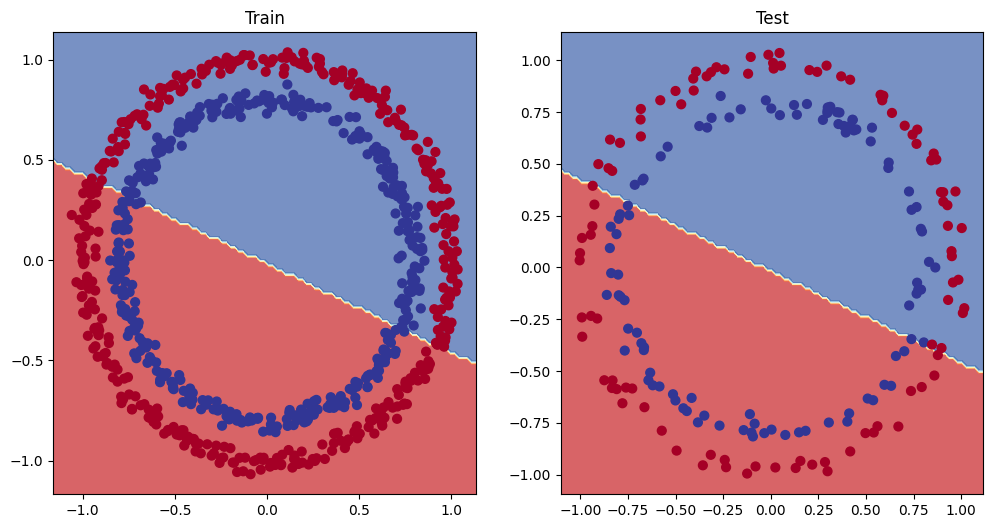

In [22]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_01, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_01, X_test, y_test)

**Let's try to add more hidden layers and neurons per layer to see if that's the issue**

In [23]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x): # note: always make sure forward is spelt correctly!
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [25]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss:{test_loss}")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss:0.6926146745681763
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss:0.6937904357910156
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss:0.6943727135658264
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss:0.6945767998695374
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss:0.6946452260017395
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss:0.6946680545806885
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss:0.6946756839752197
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss:0.6946782469749451
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss:0.6946790814399719
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss:0.6946793794631958


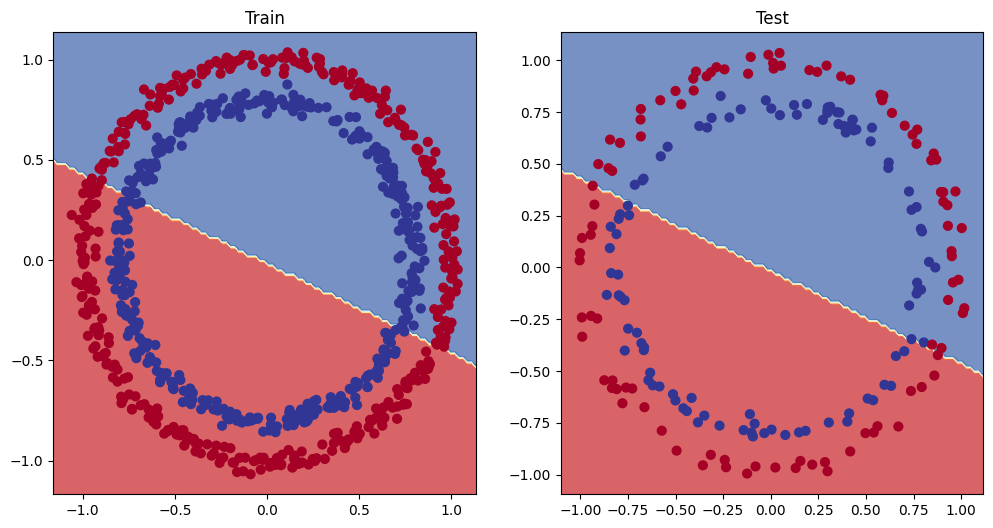

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

**We can clearly see that wasn't the problem, the model is linear, we need to add a non-linerity, to do so we'll use ReLU**

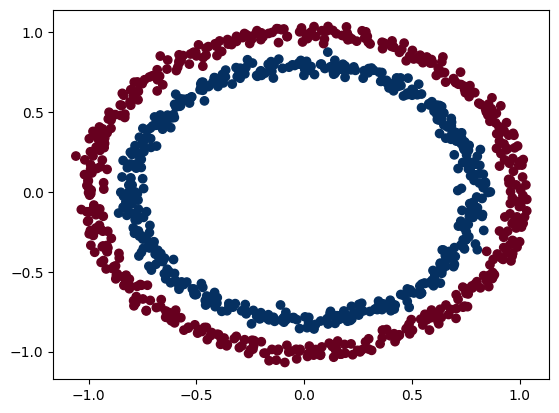

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [28]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [29]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features =2, out_features = 16)
    self.layer_2 = nn.Linear(in_features =16, out_features = 16)
    self.layer_3 = nn.Linear(in_features =16, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [30]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(),
                             lr = 0.1)

In [31]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
      test_logits = model_2(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.69753, Accuracy: 50.00% | Test Loss: 0.6978390216827393
Epoch: 100 | Loss: 0.68987, Accuracy: 56.25% | Test Loss: 0.6913948655128479
Epoch: 200 | Loss: 0.68663, Accuracy: 52.88% | Test Loss: 0.6887485980987549
Epoch: 300 | Loss: 0.68264, Accuracy: 53.62% | Test Loss: 0.6857616901397705
Epoch: 400 | Loss: 0.67735, Accuracy: 54.00% | Test Loss: 0.6818865537643433
Epoch: 500 | Loss: 0.67006, Accuracy: 56.00% | Test Loss: 0.6763973236083984
Epoch: 600 | Loss: 0.65938, Accuracy: 62.38% | Test Loss: 0.6677736639976501
Epoch: 700 | Loss: 0.64168, Accuracy: 75.50% | Test Loss: 0.6532543897628784
Epoch: 800 | Loss: 0.61284, Accuracy: 87.38% | Test Loss: 0.6288638114929199
Epoch: 900 | Loss: 0.56398, Accuracy: 97.25% | Test Loss: 0.5872305631637573


In [32]:
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

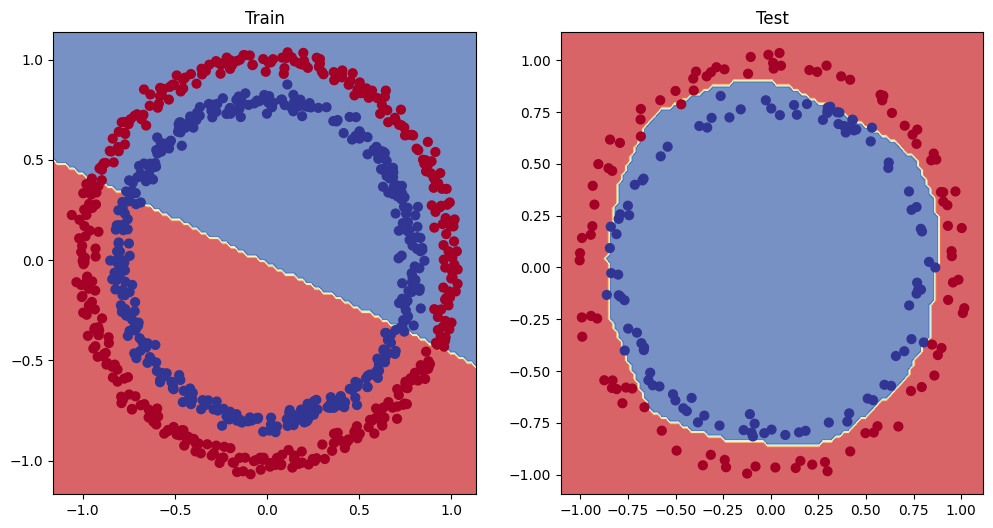

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_2 = has non-linearity

#**84 Overview with a multiclass classification problem**


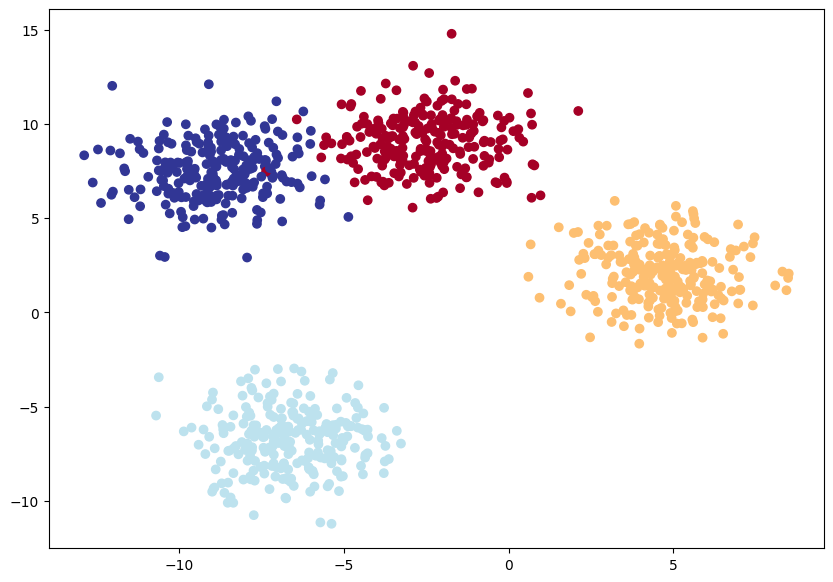

In [50]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

N_Class = 4
N_Feautres = 2
Rand_Seed = 42

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = N_Feautres,
                            centers = N_Class,
                            cluster_std = 1.5,
                            random_state = Rand_Seed)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test , y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                         y_blob,
                                                                         test_size = 0.2,
                                                                         random_state = Rand_Seed)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c = y_blob , cmap = plt.cm.RdYlBu)

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [52]:
class BlobModel(nn.Module):
  def __init__(self,input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features,out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features = output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model_blob = BlobModel(input_features = 2,
                       output_features = N_Class).to(device)

model_blob

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_blob.parameters(),
                            lr=0.1)

In [54]:
torch.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

    model_blob.train()
    y_logits = model_blob(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_blob.eval()
    with torch.inference_mode():
      test_logits = model_blob(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss}")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.0755419731140137
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.6606872081756592
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074119091033936
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24507619440555573
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10228516906499863
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.058475375175476074
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.042932283133268356
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03490966185927391
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.029878225177526474
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.026626527309417725


In [55]:
model_blob.eval()
with torch.inference_mode():
    y_logits = model_blob(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [56]:
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


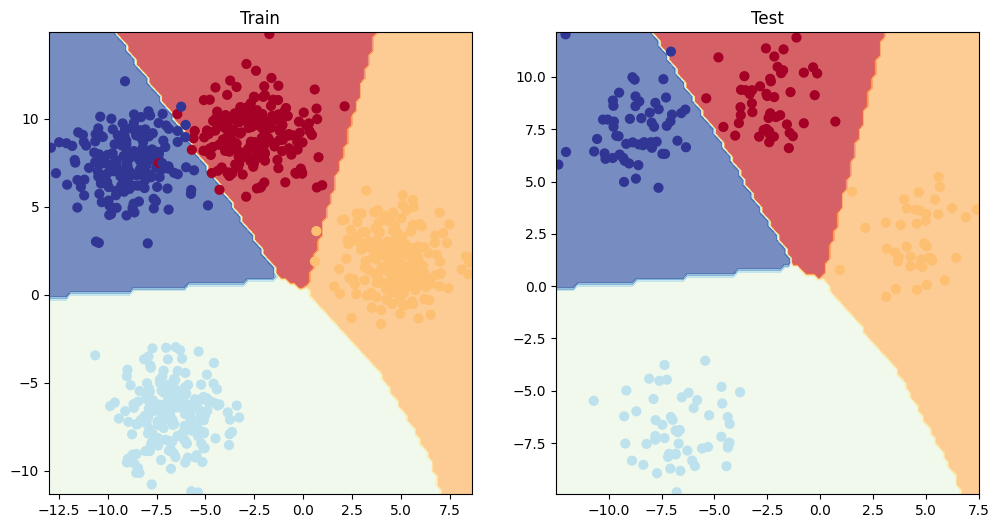

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_blob, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_blob, X_blob_test, y_blob_test)